<a href="https://colab.research.google.com/github/rahiakela/modern-computer-vision-with-pytorch/blob/main/7-basics-of-object-detection/1_understanding_region_proposals.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Understanding region proposals

Imagine a hypothetical scenario where the image of interest contains a person and sky in the background. Furthermore, for this scenario, let's assume that there is little change in pixel intensity of the background (sky) and that there is a considerable change in pixel intensity of the foreground (the person). 

Just from the preceding description itself, we can conclude that there are two primary regions here – one is of the person and the other is of the sky. Furthermore, within the region of the image of a person, the pixels corresponding to hair will have a different intensity to the pixels corresponding to the face, establishing that there can be multiple sub-regions within a region.

**Region proposal is a technique that helps in identifying islands of regions where the pixels are similar to one another.**

Generating a region proposal comes in handy for object detection where we have to identify the locations of objects present in the image. Furthermore, given a region proposal generates a proposal for the region, it aids in object localization where the task is to identify a bounding box that fits exactly around the object in the image. We will learn how region proposals assist in object localization and detection in a later section on Training R-CNN-based custom object detectors, but let's first understand how to generate region proposals from an image.



## Setup

In [ ]:
%%shell

pip install selectivesearch
pip install torch_snippets

In [2]:
from torch_snippets import *
import selectivesearch
from skimage.segmentation import felzenszwalb

## Leveraging SelectiveSearch to generate region proposals

SelectiveSearch is a region proposal algorithm used for object localization where it generates proposals of regions that are likely to be grouped together based on their pixel intensities. SelectiveSearch groups pixels based on the hierarchical grouping of similar pixels, which, in turn, leverages the color, texture, size, and shape compatibility of content within an image.

Initially, SelectiveSearch over-segments an image by grouping pixels based on the preceding attributes. Next, it iterates through these over-segmented groups and groups them based on similarity. At each iteration, it combines smaller regions to form a larger region.

Let's understand the selectivesearch process through the following example:

In [ ]:
# Fetch and load the required image:
!wget https://raw.githubusercontent.com/rahiakela/modern-computer-vision-with-pytorch/main/7-basics-of-object-detection/images/image-1/image-1.jpeg
img = read("image-1.jpeg", 1)

Extract the felzenszwalb segments (which are obtained based on the color, texture, size, and shape compatibility of content within an image) from the image.

2020-12-21 09:35:58.515 | INFO     | torch_snippets.loader:subplots:385 - plotting 2 images in a grid of 1x2 @ (10, 10)


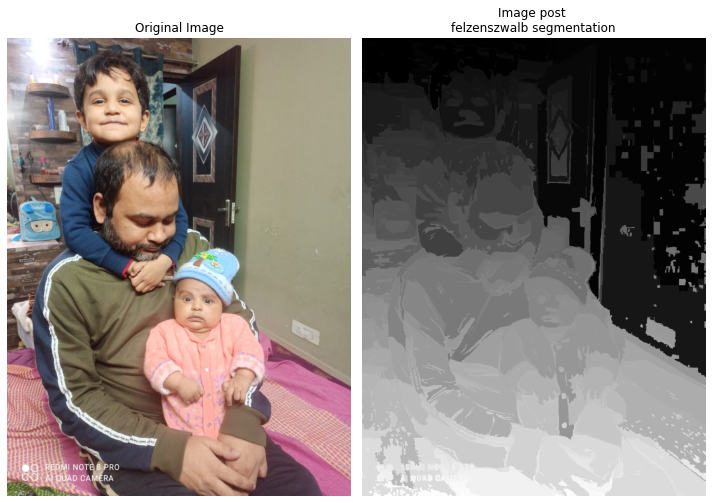

In [5]:
segments_fz = felzenszwalb(img, scale=200)
subplots([img, segments_fz], titles=["Original Image", "Image post \nfelzenszwalb segmentation"], figsize=(10, 10), nc=2)

Note that in the felzenszwalb method, scale represents the number of clusters that can be formed within the segments of the image. The higher the value of scale, the greater the detail of the original image that is preserved.

2020-12-21 09:38:24.812 | INFO     | torch_snippets.loader:subplots:385 - plotting 2 images in a grid of 1x2 @ (10, 10)


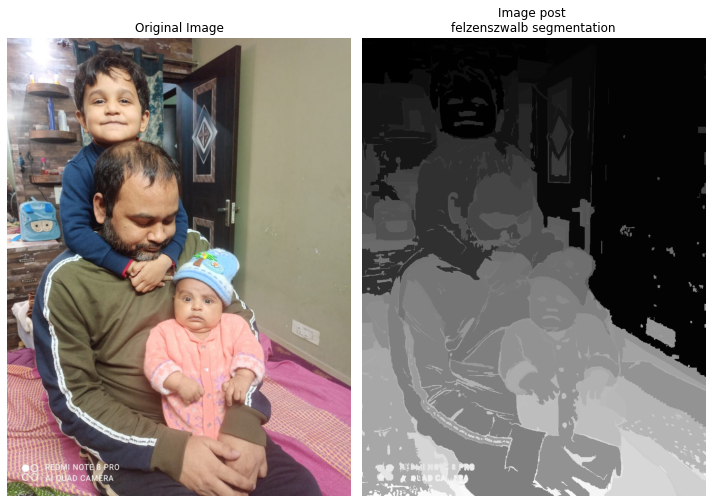

In [6]:
segments_fz = felzenszwalb(img, scale=400)
subplots([img, segments_fz], titles=["Original Image", "Image post \nfelzenszwalb segmentation"], figsize=(10, 10), nc=2)

2020-12-21 09:38:48.953 | INFO     | torch_snippets.loader:subplots:385 - plotting 2 images in a grid of 1x2 @ (10, 10)


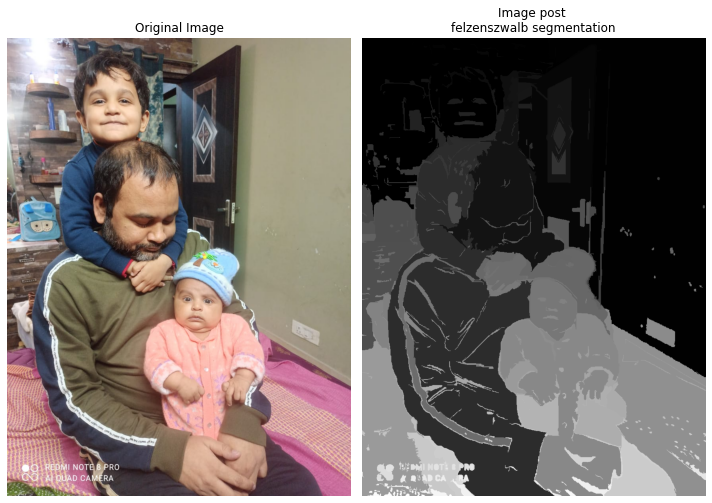

In [7]:
segments_fz = felzenszwalb(img, scale=800)
subplots([img, segments_fz], titles=["Original Image", "Image post \nfelzenszwalb segmentation"], figsize=(10, 10), nc=2)

Now that we understand what SelectiveSearch does, let's implement the selectivesearch function to fetch region proposals for the given image.

## Implementing SelectiveSearch to generate region proposals

we will define the extract_candidates function using selectivesearch so that it can be leveraged in the subsequent sections on training R-CNN- and Fast R-CNN-based custom object detectors:

In [8]:
def extract_candidates(img):
  # Fetch the candidate regions within the image using the selective_search method 
  img_label, regions = selectivesearch.selective_search(img, scale=200, min_size=100)
  img_area = np.prod(img.shape[:2])
  candidates = []
  # Fetch only those candidates (regions) that are over 5% of the total image area and less than or equal to 100% of the image area
  for r in regions:
    if r["rect"] in candidates: 
      continue
    if r["size"] < (0.05 * img_area):
      continue
    if r["size"] > (1 * img_area):
      continue
    x, y, w, h = r["rect"]
    candidates.append(list(r["rect"]))
  return candidates

Extract candidates and plot them on top of an image

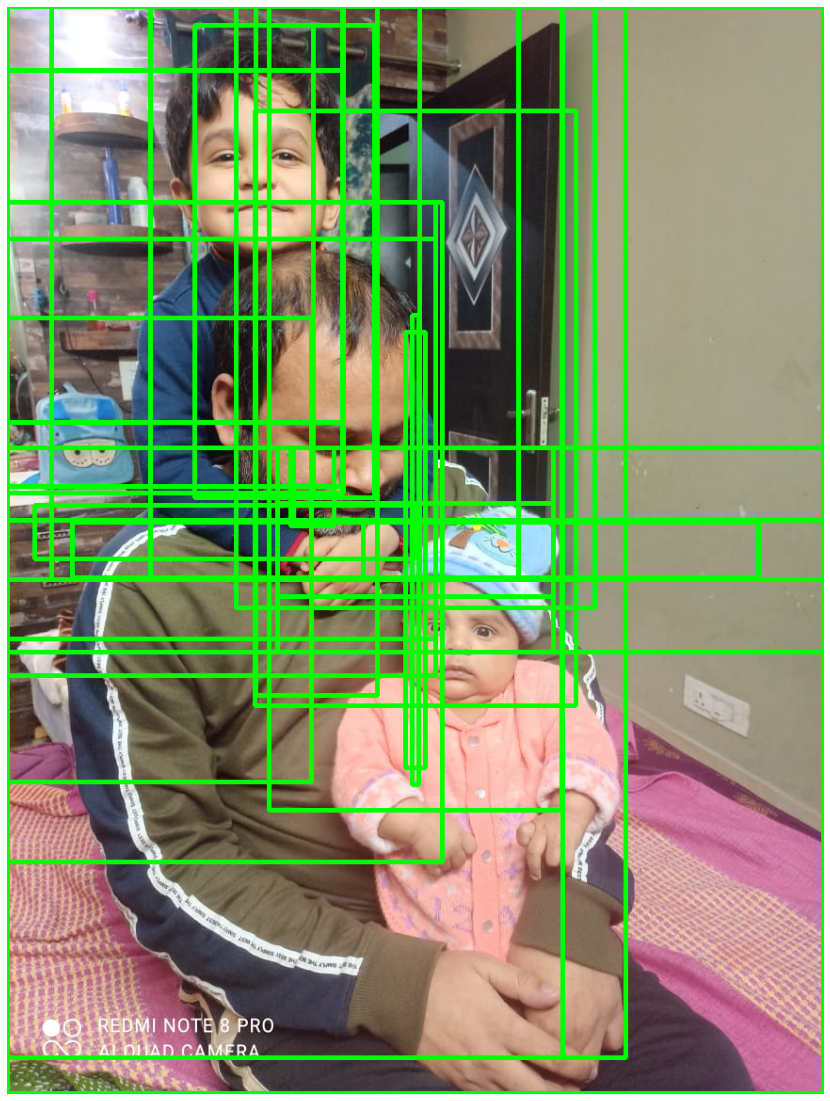

In [9]:
candidates = extract_candidates(img)
show(img, bbs=candidates)

The grids in the preceding diagram represent the candidate regions (region proposals) coming from the selective_search method.

Now that we understand region proposal generation, one question remains unanswered. How do we leverage region proposals for object detection and localization?

**A region proposal that has a high intersection with the location (ground truth) of an object in the image of interest is labeled as the one that contains the object, and a region proposal with a low intersection is labeled as background.**

we will learn about how to calculate the intersection of a region proposal candidate with a ground truth bounding box in our journey to understanding the various techniques that form the backbone of building an object detection model.